In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

ds_ = ds.sel(time=ds.time.dt.hour == 0)
ds_ = ds_.sel(time=ds_.time.dt.season == "JJA")

In [7]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [9]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_sst = open_da(
    "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_mslp = open_da(
    "ERA5", "surf", "mslp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_apvs = open_da(
    "ERA5", "thetalev", "apvs", "dailymean", "all", None, None, None, None, None, "all",
)
da_cpvs = open_da(
    "ERA5", "thetalev", "cpvs", "dailymean", "all", None, None, None, None, None, "all",
)
da_z = open_da(
    "ERA5", "plev", "z", "dailymean", "all", "JJA", None, None, None, None, 500, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [ ]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells = get_persistent_spell_times_from_som(labels, dists, sigma, 32, nt_before=20, nojune=True, daily=True)

# Honeycomb anomaly plots

In [11]:
labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)

## occurence, lengths

(<Figure size 500x400 with 2 Axes>, <Axes: >)

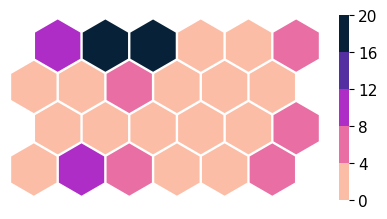

In [12]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

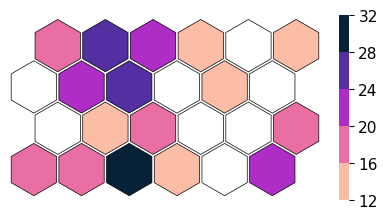

In [13]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

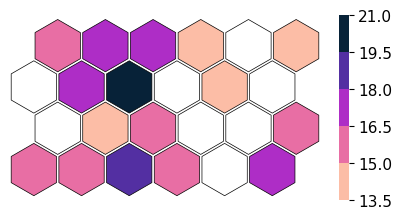

In [14]:
## mean len
len_per_cluster = spells.group_by("value").len()
len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(len_per_cluster, how="left", on="value").fill_null(0)
len_per_cluster = len_per_cluster.with_columns(pl.col("len") / spells_per_cluster["len"])
cmap = colormaps.bubblegum_r
net.plot_on_map(len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

In [15]:
transpose_order = np.arange(24).reshape(4, 6).transpose().flatten()
numbering_trans = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in transpose_order]
numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in np.arange(24)]

## jet indices

In [16]:
props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet", ), 31, True)

In [17]:
props_masked = mask_from_spells_pl(spells, props_as_df_anoms)
props_masked_ = props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(24)).to_frame().join(props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_ = indexer.join(props_masked_, how="left", on=["cluster", "jet", "relative_index"])

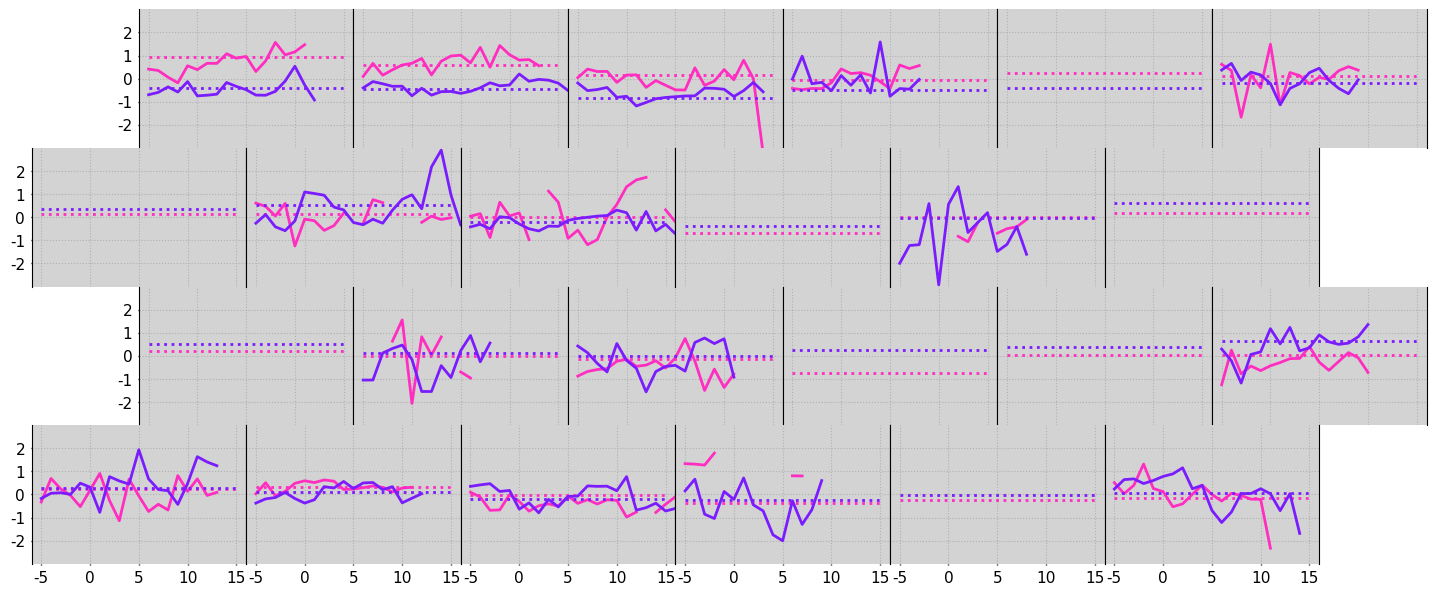

In [18]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lat"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").dt.month().is_in([6, 7, 8]), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 16])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

In [20]:
from jetstream_hugo.jet_finding import find_all_jets
all_jets_center = find_all_jets(xarray_to_polars(ds_center), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center = is_polar_gmix(all_jets_center, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

100%|██████████| 24/24 [00:00<00:00, 444.59it/s]


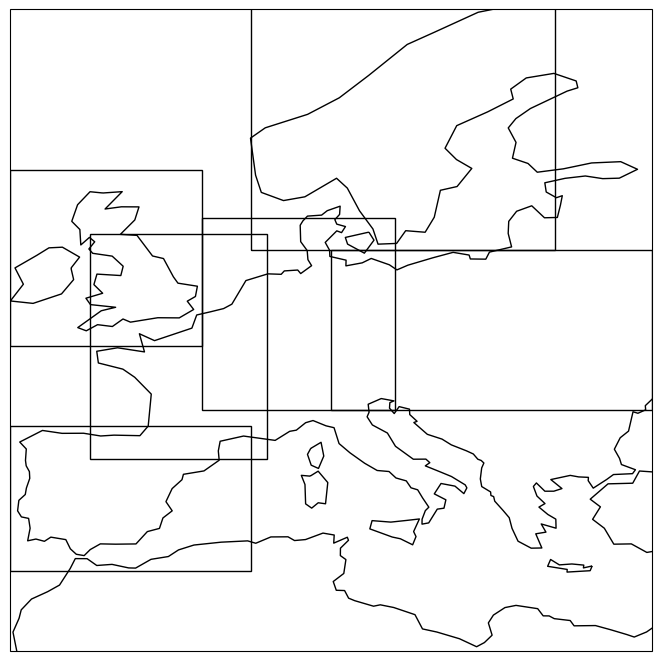

In [21]:
import matplotlib.patches as mpatches
clu = Clusterplot(1, 1, (-10, 30, 30, 70))
ax = clu.axes[0]
regions = [
    (-10, 2, 49, 60),
    (-5, 6, 42, 56),
    (-10, 5, 35, 44),
    (2, 14, 45, 57),
    (10, 30, 45, 55),
    (5, 24, 55, 71),
]
for region in regions:
    x1, x2, y1, y2 = region 
    ax.add_patch(
        mpatches.Rectangle(
            xy=[x1, y1], 
            width=x2 - x1, height=y2 - y1,
            facecolor='none', 
            edgecolor='k',
            transform=ccrs.PlateCarree()
        )
    )

## Wind

### overall

In [ ]:
ds_ = compute(ds_, progress_flag=True)

In [ ]:
clu = Clusterplot(4, 6, honeycomb=True, region=get_region(da_s), numbering=True)
_ = clu.add_any_contour_from_mask(ds_["s"], mask_daily, cmap=colormaps.darkmint, levels=6, q=1-1e-3)
axes = clu.axes.ravel()
for i, jets in all_jets_center.group_by("cluster", maintain_order=True):
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i[0]].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

### spells

In [ ]:
uvs_masked = mask_from_spells_pl(spells, ds_)

In [ ]:
uvs_masked_per_cluster = uvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = uvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
uvs_masked_per_cluster = uvs_masked_per_cluster.sel(cluster=indexer)
uvs_masked_per_cluster = uvs_masked_per_cluster.assign_coords(cluster=np.arange(24))
uvs_masked_per_cluster.loc[{"cluster": to_zero}] = 0.
jets_masked = find_all_jets(xarray_to_polars(uvs_masked_per_cluster), base_s_thresh=30)

In [ ]:
clu = Clusterplot(4, 6, honeycomb=True, region=get_region(da_s), numbering=numbering)
_ = clu.add_contourf(uvs_masked_per_cluster["s"].sel(relative_index=0), cmap=colormaps.darkmint, levels=6, q=1-1e-3)
axes = clu.axes.ravel()
for i, jets in jets_masked.filter(pl.col("relative_index") == 0).group_by("cluster", maintain_order=True):
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i[0]].scatter(lo, la, lw=1, s=10)

In [ ]:
clu = Clusterplot(4, 6, honeycomb=True, region=get_region(da_s), numbering=numbering)
_ = clu.add_contourf(uvs_masked_per_cluster["s"].sel(relative_index=1), cmap=colormaps.darkmint, levels=6, q=1-1e-3)
axes = clu.axes.ravel()
for i, jets in jets_masked.filter(pl.col("relative_index") == 1).group_by("cluster", maintain_order=True):
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i[0]].scatter(lo, la, lw=1, s=10)

## Temperature

### Overall

In [22]:
da_T = compute(da_T.sel(time=da_T.time.dt.season == "JJA"))

100%|██████████| 24/24 [00:01<00:00, 13.34it/s]


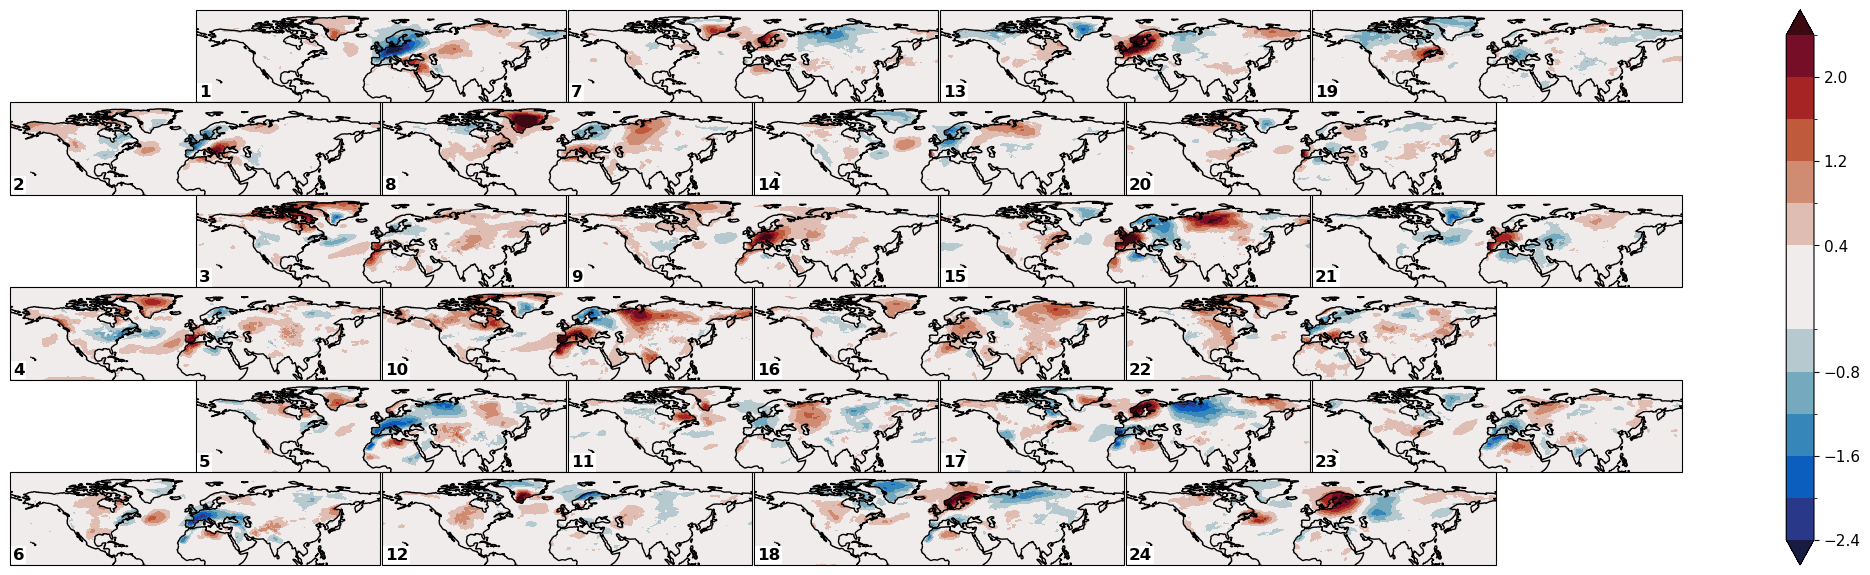

In [23]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_T), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_T, mask_daily[:, transpose_order], cmap=colormaps.balance, levels=12, q=1-1e-3)

100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


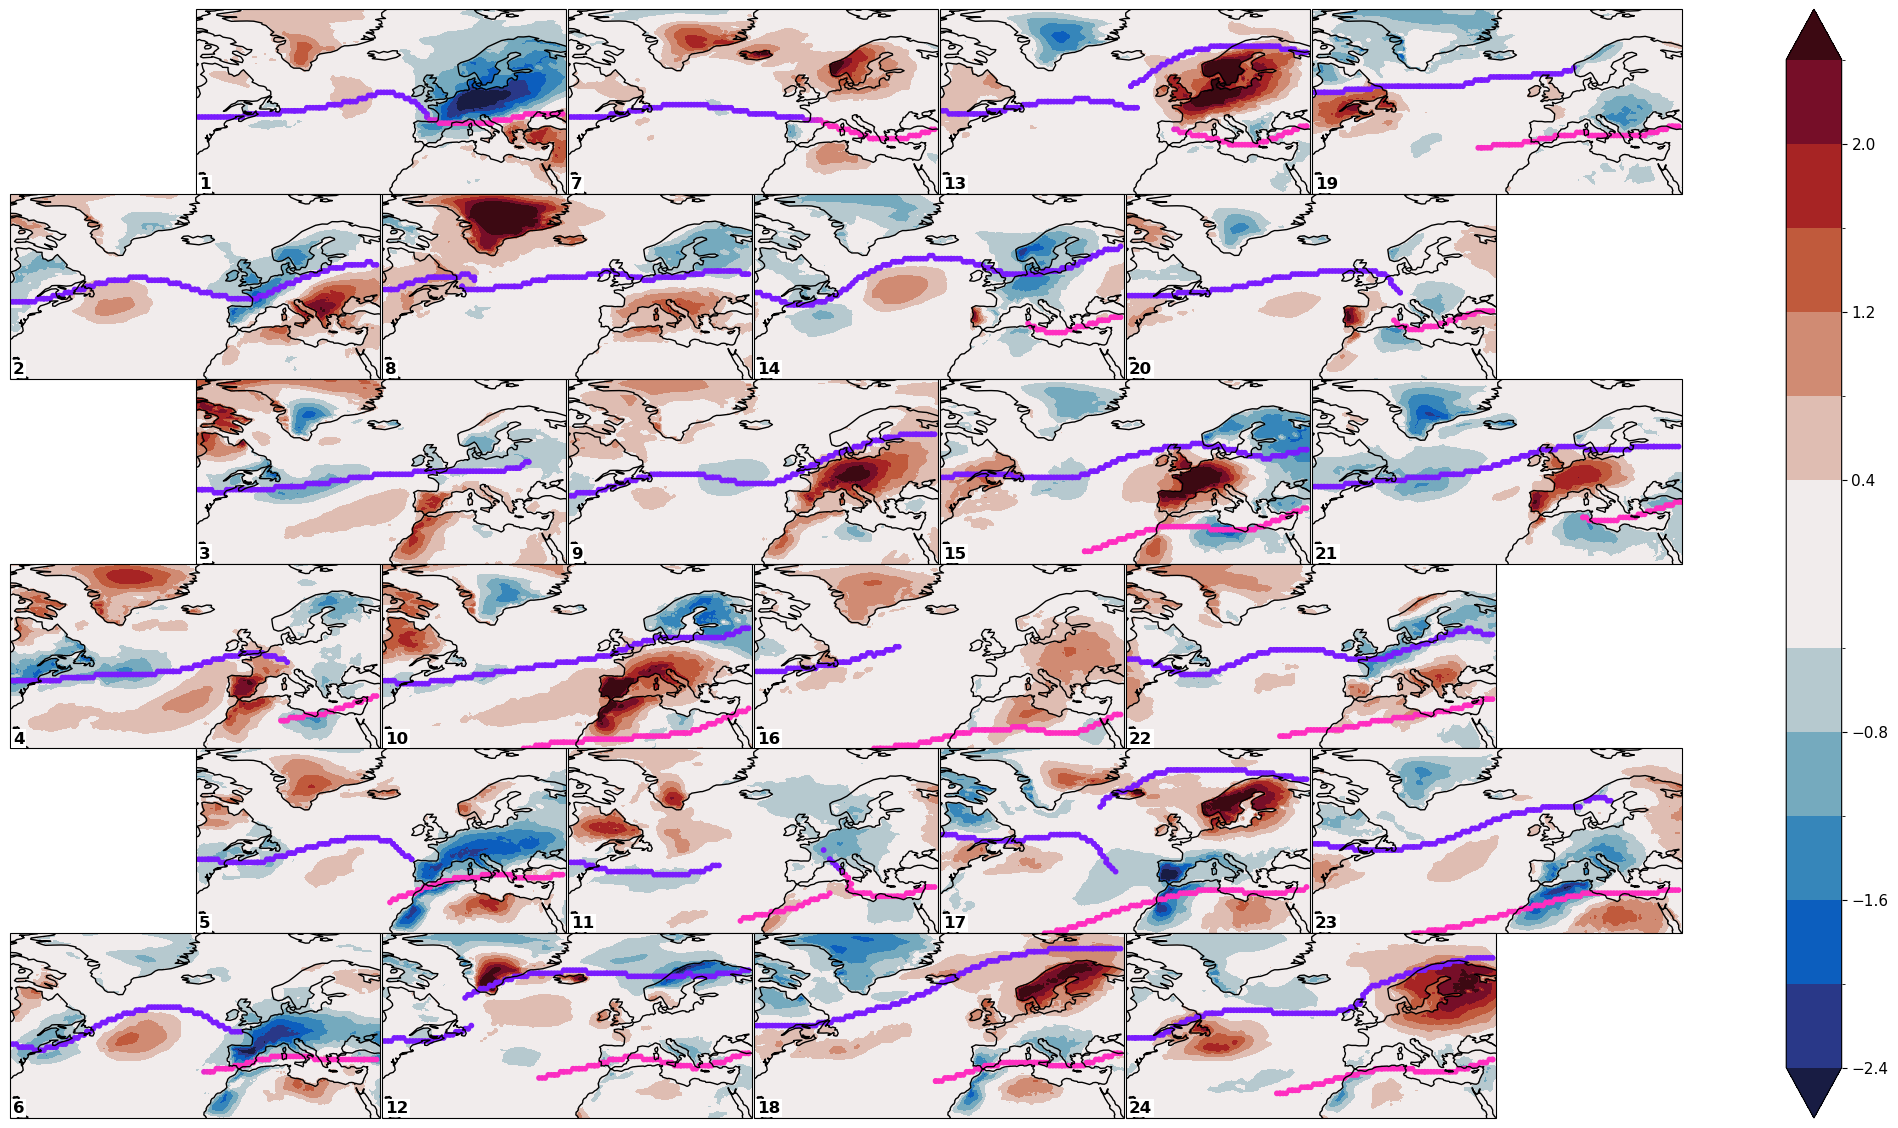

In [31]:
clu = Clusterplot(6, 4, honeycomb=True, region=(-80, 40, 20, 80), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_T, mask_daily[:, transpose_order], cmap=colormaps.balance, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(24):
    jets = all_jets_center.filter(pl.col("cluster") == transpose_order[i])
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

### spells

In [25]:
T_masked = mask_from_spells_pl(spells, da_T)

In [26]:
T_masked_per_cluster = T_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
T_masked_per_cluster[to_zero, ...] = 0.
T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(24))

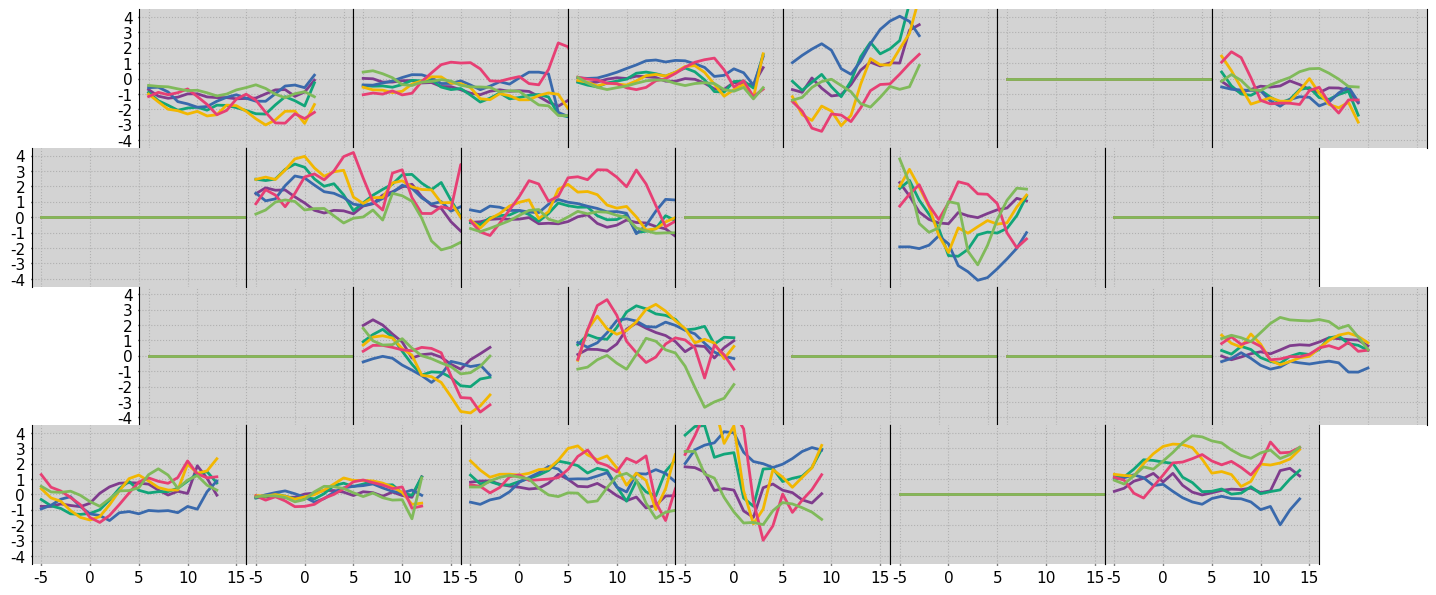

In [27]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
colors = colormaps.bold(np.arange(len(regions)))
rel_ind_ticks = [-5, 0, 5, 10, 15]
temp_ticks = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
for k, (region, color) in enumerate(zip(regions, colors)):
    to_plot = extract_region(T_masked_per_cluster, *region).mean(["lon", "lat"])
    for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
        ax.spines[["top", "bottom"]].set_visible(False)
        to_plot_ = to_plot.sel(cluster=l)
        ax.plot(to_plot_["relative_index"], to_plot_, color=color, lw=2)
        if k == 0:   
            ax.grid(linestyle="dotted")
            ax.set_xlim([-6, 16])
            ax.set_ylim([-4.5, 4.5])
            ax.set_facecolor('lightgray')
            if i == 3:
                ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
                ax.tick_params(axis='x', width=1, size=1)
            else:
                ax.set_xticks(rel_ind_ticks, labels=[])
                ax.tick_params(axis='x', width=0, size=0)
            if j == 0:
                ax.set_yticks(temp_ticks, labels=temp_ticks)
                ax.tick_params(axis='y', width=1, size=1)
            else:       
                ax.set_yticks(temp_ticks, labels=[])
                ax.tick_params(axis='y', width=0, size=0)

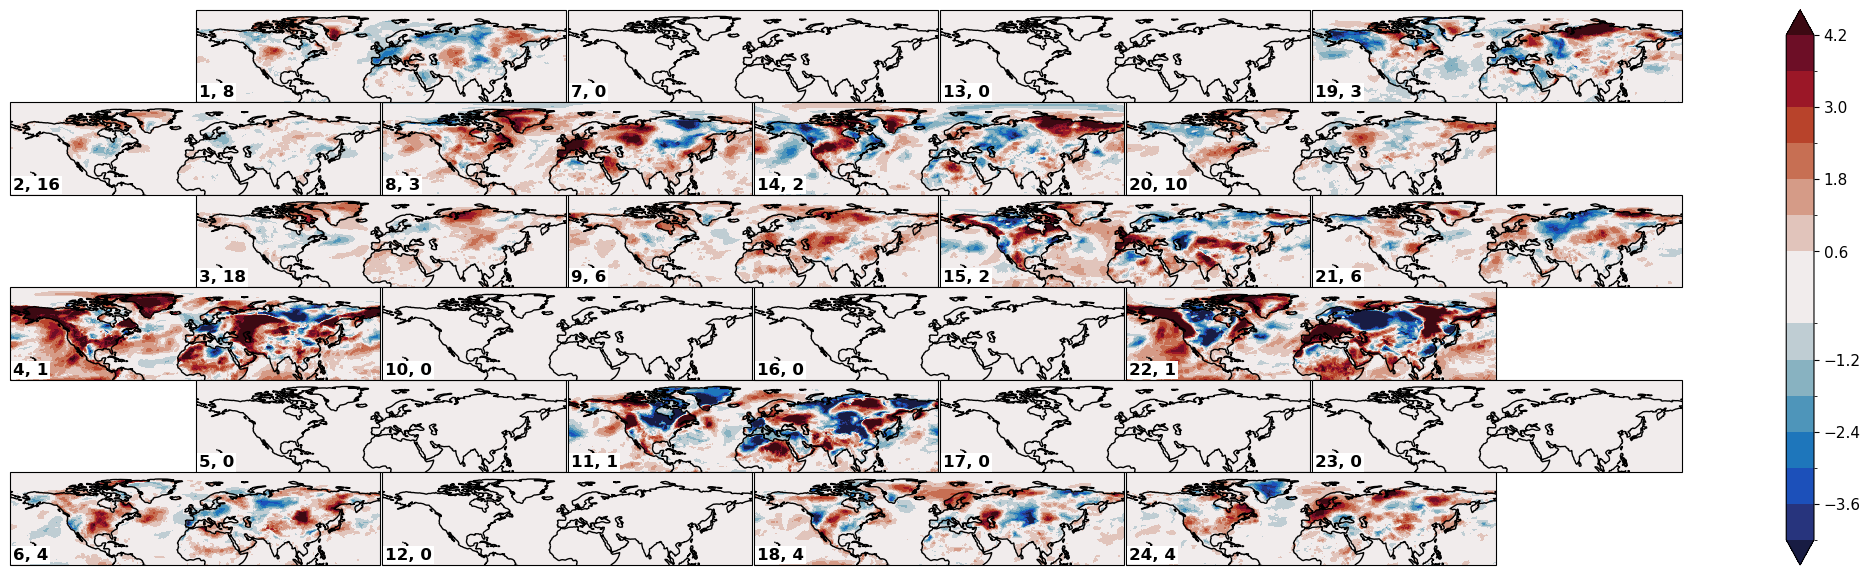

In [28]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_T), numbering=numbering_trans)
_ = clu.add_contourf(T_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap=colormaps.balance, levels=13, q=1-1e-2)

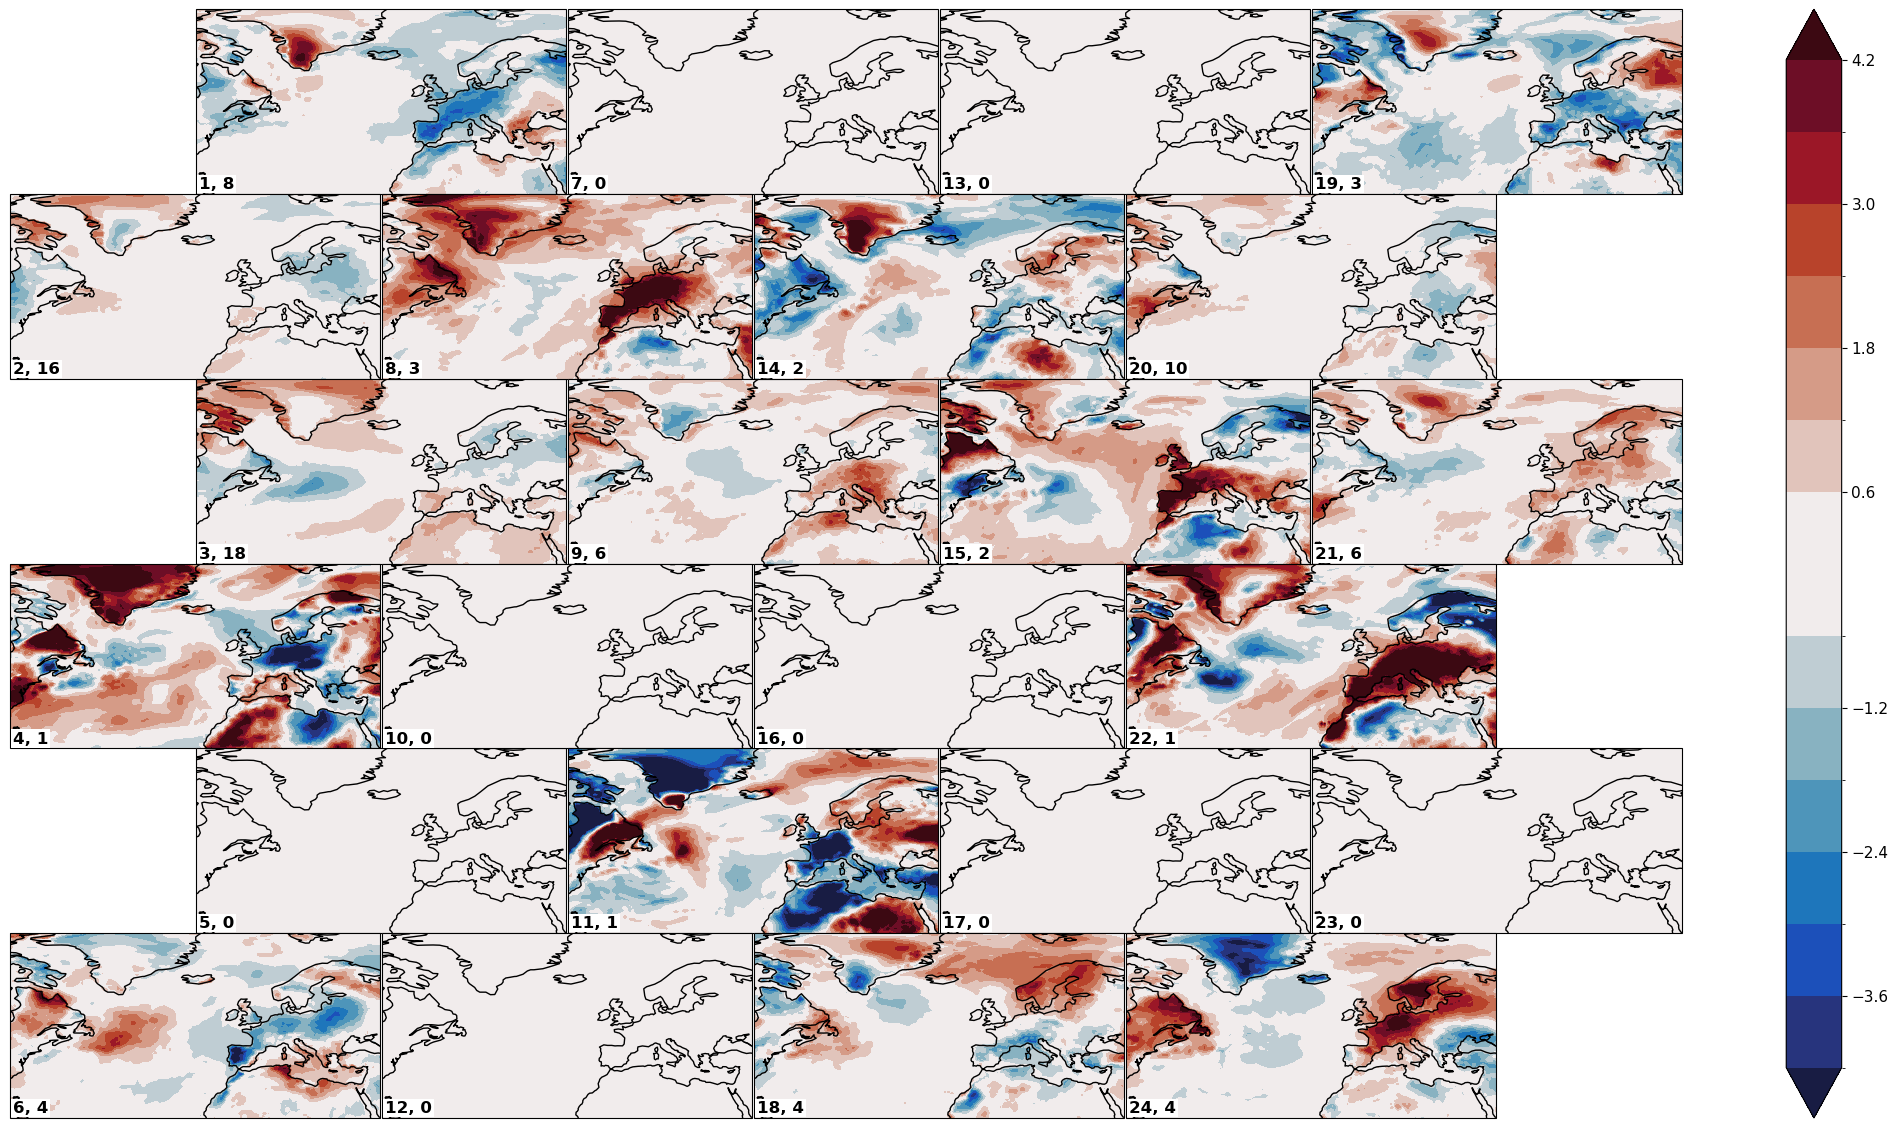

In [30]:
clu = Clusterplot(6, 4, honeycomb=True, region=(-80, 40, 20, 80), numbering=numbering_trans)
_ = clu.add_contourf(T_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap=colormaps.balance, levels=13)
axes = clu.axes.ravel()
# for i in range(24):
#     jets = jets_masked.filter(pl.col("cluster") == transpose_order[i], pl.col("relative_index") == 0)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la = jet[["lon", "lat"]].to_numpy().T
#         axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_T), numbering=numbering_trans)
_ = clu.add_contourf(T_masked_per_cluster.sel(relative_index=-2).isel(cluster=transpose_order), cmap=colormaps.balance, levels=11)

## precip


### overall

In [ ]:
da_tp = compute(da_tp.sel(time=da_tp.time.dt.season == "JJA"), progress_flag=True)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_tp), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_tp, mask_daily[:, transpose_order], cmap="BrBG", levels=13)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=(-80, 40, 15, 80), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_tp, mask_daily[:, transpose_order], cmap="BrBG", levels=9)
axes = clu.axes.ravel()
for i in range(24):
    jets = all_jets_center.filter(pl.col("cluster") == transpose_order[i])
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

### spells

In [ ]:
tp_masked = mask_from_spells_pl(spells, da_tp)

In [ ]:
tp_masked_per_cluster = tp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = tp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
tp_masked_per_cluster = tp_masked_per_cluster.sel(cluster=indexer)
tp_masked_per_cluster[to_zero, ...] = 0.
tp_masked_per_cluster = tp_masked_per_cluster.assign_coords(cluster=np.arange(24))

In [ ]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
colors = colormaps.bold(np.arange(len(regions)))
rel_ind_ticks = [-5, 0, 5, 10, 15]
tp_ticks = [-2, -1, 0, 1, 2]
for k, (region, color) in enumerate(zip(regions, colors)):
    to_plot = extract_region(tp_masked_per_cluster * 10000, *region).mean(["lon", "lat"])
    for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
        ax.spines[["top", "bottom"]].set_visible(False)
        to_plot_ = to_plot.sel(cluster=l)
        ax.plot(to_plot_["relative_index"], to_plot_, color=color, lw=2)
        if k == 0:   
            ax.grid(linestyle="dotted")
            ax.set_xlim([-6, 16])
            ax.set_ylim([-2.5, 2.5])
            ax.set_facecolor('lightgray')
            if i == 3:
                ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
                ax.tick_params(axis='x', width=1, size=1)
            else:
                ax.set_xticks(rel_ind_ticks, labels=[])
                ax.tick_params(axis='x', width=0, size=0)
            if j == 0:
                ax.set_yticks(tp_ticks, labels=tp_ticks)
                ax.tick_params(axis='y', width=1, size=1)
            else:       
                ax.set_yticks(tp_ticks, labels=[])
                ax.tick_params(axis='y', width=0, size=0)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_tp), numbering=numbering_trans)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap="BrBG", levels=13)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=(-80, 40, 20, 80), numbering=numbering_trans)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap="BrBG", levels=13)
axes = clu.axes.ravel()
for i in range(24):
    jets = jets_masked.filter(pl.col("cluster") == transpose_order[i], pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

### relative time plots

In [ ]:
transpose_order = np.arange(24).reshape(4, 6).transpose().flatten()
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_tp), numbering=numbering_trans)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=-2).isel(cluster=transpose_order), cmap=colormaps.brbg, levels=9)

In [ ]:
clu = Clusterplot(4, 2, (-120, 60, 0, 90))
_ = clu.add_contourf(
    tp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 19
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 13
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 23
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 18
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 1
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

In [ ]:
clu = Clusterplot(4, 2, (-100, 60, 0, 90))
relative_indexes = np.arange(8)
cluster = 3
_ = clu.add_contourf(
    tp_masked.sel(spell=tp_masked.value == cluster).mean("spell").isel(relative_index=relative_indexes),
    levels=7,
    cmap=colormaps.brbg,
    titles=tp_masked.relative_time[relative_indexes].values.astype("timedelta64[D]"),
)
axes = clu.axes
for i in relative_indexes:
    jets = all_jets_center.filter(pl.col("cluster") == cluster)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="grey")
    jets = jets_masked.filter(pl.col("cluster") == cluster, pl.col("relative_index") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")

## sst

### overall

In [ ]:
da_sst = compute(da_sst.sel(time=da_sst.time.dt.season == "JJA"), progress_flag=True)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_sst), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_sst, mask_daily[:, transpose_order], cmap=colormaps.balance, levels=9)

### spells

In [ ]:
sst_masked = mask_from_spells_pl(spells, da_sst)

In [ ]:
sst_masked_per_cluster = sst_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = sst_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
sst_masked_per_cluster = sst_masked_per_cluster.sel(cluster=indexer)
sst_masked_per_cluster[to_zero, ...] = 0.
sst_masked_per_cluster = sst_masked_per_cluster.assign_coords(cluster=np.arange(24))

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_sst), numbering=numbering_trans)
_ = clu.add_contourf(sst_masked_per_cluster.sel(relative_index=-2).isel(cluster=transpose_order), cmap=colormaps.balance, levels=15)

## apvs


### overall

In [ ]:
da_apvs = compute(da_apvs.sel(time=da_apvs.time.dt.season == "JJA", lev=350), progress_flag=True)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_apvs), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_apvs, mask_daily[:, transpose_order], cmap=colormaps.curl, levels=9)

### spells

In [ ]:
apvs_masked = mask_from_spells_pl(spells, da_apvs.reset_coords("lev", drop=True))

In [ ]:
apvs_masked_per_cluster = apvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = apvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
apvs_masked_per_cluster = apvs_masked_per_cluster.sel(cluster=indexer)
apvs_masked_per_cluster[to_zero, ...] = 0.
apvs_masked_per_cluster = apvs_masked_per_cluster.assign_coords(cluster=np.arange(24))

In [ ]:
import matplotlib.patches as mpatches
clu = Clusterplot(1, 1, get_region(da_apvs))
_ = clu.add_contourf([np.abs(da_apvs).mean("time")], cmap=colormaps.tempo, levels=9)
ax = clu.axes[0]
region = (-75, -35, 30, 50)
# region = (-80, -30, 25, 55)
x1, x2, y1, y2 = region 
ax.add_patch(
    mpatches.Rectangle(
        xy=[x1, y1], 
        width=x2 - x1, height=y2 - y1,
        facecolor='none', 
        edgecolor='k',
        transform=ccrs.PlateCarree()
    )
)

In [ ]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
rel_ind_ticks = [-5, 0, 5, 10, 15]
to_plot = extract_region(apvs_masked_per_cluster, *region).mean(["lon", "lat"])
anom_ticks = MaxNLocator(8, symmetric=True).tick_values(to_plot.quantile(0.02), to_plot.quantile(0.99))
apvs_region_summer = extract_region(da_apvs, *region).mean(["lon", "lat"])
apvs_region_summer_on_map = [apvs_region_summer[mask_daily_].mean() for mask_daily_ in mask_daily.T]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    to_plot_ = to_plot.sel(cluster=l)
    ax.plot(to_plot_["relative_index"], to_plot_, color="black", lw=2)
    ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [apvs_region_summer_on_map[l], apvs_region_summer_on_map[l]], color="black", lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 16])
    ax.set_ylim([anom_ticks[0] - 0.5, anom_ticks[-1] + 0.5])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_apvs), numbering=numbering_trans)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap=colormaps.curl, levels=9)

In [ ]:
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_apvs), numbering=numbering_trans)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=-4).isel(cluster=transpose_order), cmap=colormaps.curl, levels=9)

## mslp


### overall

In [ ]:
da_mslp = compute(da_mslp.sel(time=da_mslp.time.dt.season == "JJA"), progress_flag=True)

In [ ]:
transpose_order = np.arange(24).reshape(4, 6).transpose().flatten()
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_mslp), numbering=(transpose_order + 1).tolist())
_ = clu.add_any_contour_from_mask(da_mslp, mask_daily[:, transpose_order], cmap=colormaps.balance, levels=9)

### spells

In [ ]:
mslp_masked = mask_from_spells_pl(spells, da_mslp)

In [ ]:
mslp_masked_per_cluster = mslp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = mslp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(24)[~np.isin(np.arange(24), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [24])))
mslp_masked_per_cluster = mslp_masked_per_cluster.sel(cluster=indexer)
mslp_masked_per_cluster[to_zero, ...] = 0.

In [ ]:
transpose_order = np.arange(24).reshape(4, 6).transpose().flatten()
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_mslp), numbering=numbering_trans)
_ = clu.add_contourf(mslp_masked_per_cluster.sel(relative_index=0).isel(cluster=transpose_order), cmap=colormaps.balance, levels=9)

In [ ]:
transpose_order = np.arange(24).reshape(4, 6).transpose().flatten()
clu = Clusterplot(6, 4, honeycomb=True, region=get_region(da_tp), numbering=numbering_trans)
_ = clu.add_contourf(mslp_masked_per_cluster.sel(relative_index=-2).isel(cluster=transpose_order), cmap=colormaps.balance, levels=9)

# mean anomaly composites

In [ ]:
clu = Clusterplot(4, 2, get_region(da_T))
_ = clu.add_contourf(
    T_masked_per_cluster.mean("cluster").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.balance,
    titles=T_masked_per_cluster.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
T_masked.spell.shape[0]

In [ ]:
clu = Clusterplot(4, 2, get_region(da_tp))
_ = clu.add_contourf(
    tp_masked_per_cluster.mean("cluster").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    cmap="BrBG", 
    levels=13,
    titles=tp_masked_per_cluster.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)

In [ ]:
clu = Clusterplot(4, 2, get_region(da_mslp))
_ = clu.add_contourf(
    mslp_masked_per_cluster.mean("cluster").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    cmap=colormaps.balance, 
    levels=9,
    titles=mslp_masked_per_cluster.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)

In [ ]:
clu = Clusterplot(4, 2, get_region(da_sst))
_ = clu.add_contourf(
    sst_masked_per_cluster.mean("cluster").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    cmap=colormaps.balance, 
    levels=9,
    titles=sst_masked_per_cluster.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)

In [ ]:
clu = Clusterplot(4, 2, get_region(da_apvs))
_ = clu.add_contourf(
    apvs_masked_per_cluster.mean("cluster").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    cmap=colormaps.curl, 
    levels=9,
    titles=apvs_masked_per_cluster.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)